In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_score, recall_score
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For evaludation on train or val data, there are only the first two paths (for prediction label, prediction prob).
# For evaludation on test data, there are three paths (for prediction label, prediction prob, real labels).

############################## <--- change this part
pred_label_path = '/content/drive/Shareddrives/AC297r Project - RFCx /model/model_timeMask_new/prediction_label_test.csv' #'../filtered_1_output/prediction_label_val.csv'
pred_prob_path = '/content/drive/Shareddrives/AC297r Project - RFCx /model/model_timeMask_new/prediction_prob_test.csv'   # '../filtered_1_output/prediction_prob_val.csv'
real_label_path = '/content/drive/Shareddrives/AC297r Project - RFCx /test-labels.csv'
##############################

def process_data(pred_label_path, pred_prob_path):
    if pred_label_path.split('_')[-1][:-4] in ['train', 'val']:
        pred_label_df = pd.read_csv(pred_label_path, index_col=False)
        class_list = pred_label_df.columns[1:]
        true_label_df = np.zeros(pred_label_df.shape)
        true_label_df[np.arange(pred_label_df.shape[0]), 1+pred_label_df["Real Label"].astype(int)] = 1.0
        true_label_df = true_label_df[:,1::][class_list]
        prediction_label = np.array(pred_label_df)

        pred_prob_df = pd.read_csv(pred_prob_path, index_col=False)
        prediction_prob = np.array(pred_prob_df.iloc[:,1::])


    elif pred_label_path.split('_')[-1][:-4] == 'test':
        # the first columsn is id  eg: 1892_0
        pred_df = pd.read_csv(pred_label_path, index_col=False)
        pred_df = pred_df.rename(columns = {"Unnamed: 0": "id"})
        pred_df = pred_df.dropna(axis=0,how='all')
        class_list = pred_df.columns[1:]
        pred_df["id_new"]  = [ i[0] for i in pred_df.id.str.split("_").values]
        # sum labels among rows within the same test sample
        prediction_label = pred_df.groupby(by = "id_new").sum().reset_index()
        prediction_label = prediction_label.sort_values(by = "id_new")
        prediction_label = np.array(prediction_label.iloc[:,1::])
        prediction_label = (prediction_label >= 1.)*1  # the maximum cap is 1

        true_label_df = pd.read_csv(real_label_path, index_col=False)
        true_label_df = true_label_df.rename(columns = {"Unnamed: 0": "id"})
        true_label_df = true_label_df.sort_values(by = "id")[class_list]
        true_label_df = np.array(true_label_df)

        # the first columsn is id  eg: 1892_0
        pred_prob = pd.read_csv(pred_prob_path, index_col=False)
        pred_prob = pred_prob.rename(columns = {"Unnamed: 0": "id"})
        pred_prob = pred_prob.dropna(axis=0,how='all')
        pred_prob["id_new"]  = [ i[0] for i in pred_prob.id.str.split("_").values]
        # the max prob among rows within the same test sample
        prediction_prob = pred_prob.groupby(by = "id_new").max().reset_index()
        prediction_prob = prediction_prob.sort_values(by = "id_new")
        prediction_prob = np.array(prediction_prob.iloc[:,2::])

    return prediction_label,  prediction_prob, true_label_df, class_list




pred_label, pred_prob, true_label, class_list = process_data(pred_label_path, pred_prob_path)

In [ ]:
def plot_metric_class(pred_label, true_label, metric):
    plt.figure(figsize=(14, 10))
    output =  metric(pred_label, true_label)[1]
    output = dict(sorted(output.items(), key = lambda x: x[1], reverse = True))
    sns.barplot(y = list(output.keys()), x = list(output.values()), orient = "h", color = "grey")

## Precision

In [ ]:
def precision(pred_label, true_label):
    scores = {}
    for i in range(pred_label.shape[1]):
        if(pred_label[:,i].sum() >0):  # get rid of columns that have no positive prediction
            scores[class_list[i]] = precision_score(true_label[:,i], pred_label[:,i])
    return round(sum(scores.values())/len(scores),5), scores

In [ ]:
# all samples
print("Precision is", precision(pred_label,true_label)[0])

Precision is 0.32977


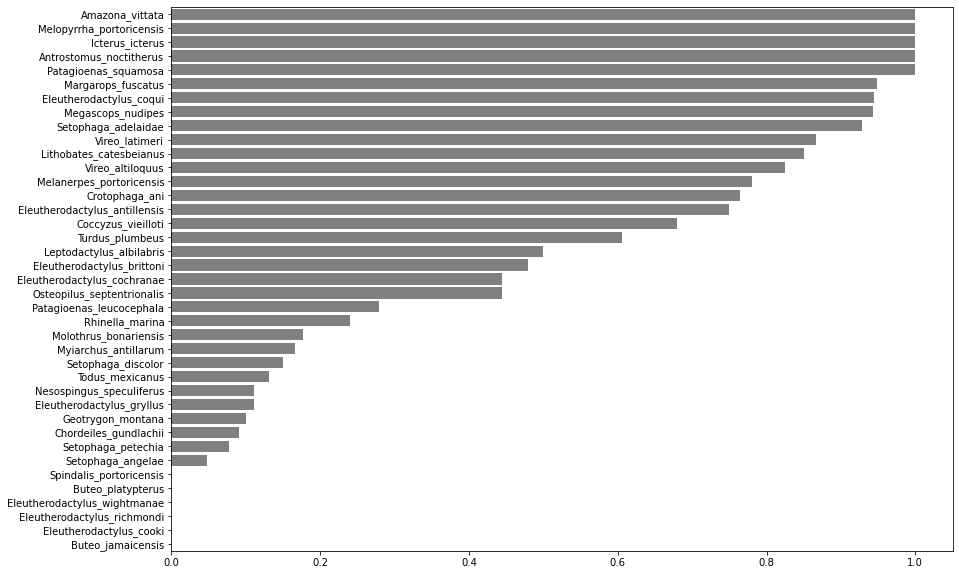

In [ ]:
plot_metric_class(pred_label,true_label,precision)

## Recall

In [ ]:
def recall(pred_label, true_label):
    scores ={}
    for i in range(pred_label.shape[1]):
        if(true_label[:,i].sum() >0):
            scores[class_list[i]] = recall_score(true_label[:,i], pred_label[:,i])
    return round(sum(scores.values())/len(scores),5), scores


In [ ]:
# all samples
print("Recall is", recall(pred_label,true_label)[0])

Recall is 0.07074


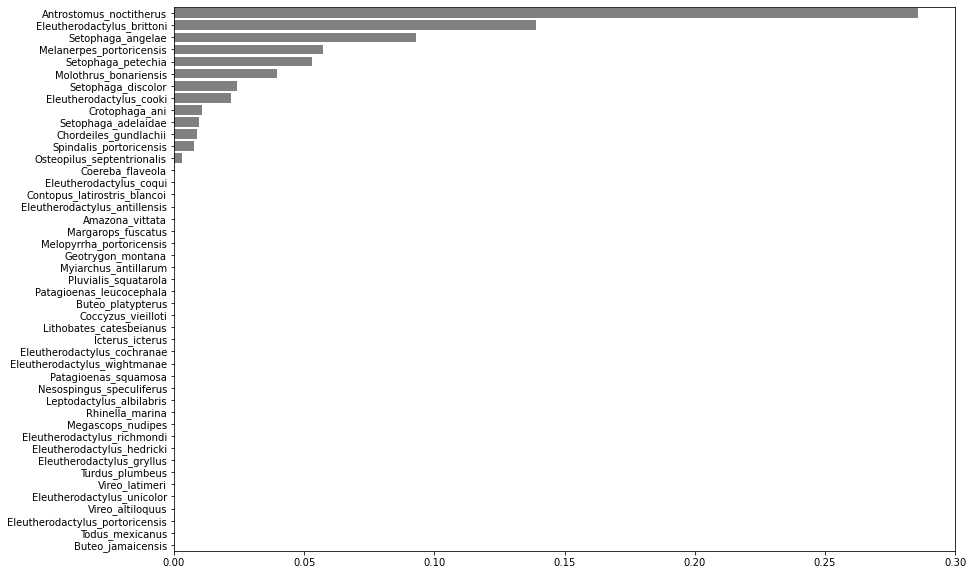

In [ ]:
plot_metric_class(pred_label,true_label,recall)

## Map /  Mean Average Precision

In [ ]:
def mAP(true_label, pred_prob): #pred_prob_df
    return round(average_precision_score(true_label, pred_prob),5)

In [ ]:
mAP(true_label, pred_prob)

0.18303

In [ ]:
pred_prob.shape

(2000, 45)

In [ ]:
labels = json.load(open('../models/baseline_model/model_classes.json', 'r'))
class_list = [labels[idx] for idx in labels]

In [ ]:
y = true_label
p = pred_prob
thresh = 0.5 # global prediction threshold
ap =[]
pos=[]
neg=[]
ppos=[]
pneg=[]
for i in range(y.shape[1]):
    tmpy = y[y[:,i]!=0.5,:]
    tmpp = p[y[:,i]!=0.5,:]
    pos.append(len(np.where(tmpy[:,i]==1)[0]))
    neg.append(len(np.where(tmpy[:,i]==0)[0]))
    ppos.append(len(np.where(tmpp[:,i]>=thresh)[0]))
    pneg.append(len(np.where(tmpp[:,i]<thresh)[0]))
    if pos[-1]==0:
        ap.append(np.nan)
    else:
        ap.append(average_precision_score(tmpy[:,i], tmpp[:,i]))
df = pd.DataFrame({'class': class_list,
                    'ap':ap,
                    'presence':pos,
                    'absence':neg,
                    'ppresence':ppos,
                    'pabsence':pneg}).sort_values(by='ap', ascending=False)



In [ ]:
df

,class,ap,presence,absence,ppresence,pabsence
16,Lithobates_catesbeianus,0.931450,22,1978,20,1980
7,Margarops_fuscatus,0.841747,394,1606,135,1865
29,Megascops_nudipes,0.707365,115,1885,35,1965
8,Melopyrrha_portoricensis,0.675993,329,1671,48,1952
19,Crotophaga_ani,0.669854,24,1976,17,1983
24,Patagioenas_squamosa,0.655702,189,1811,12,1988
23,Setophaga_adelaidae,0.652984,471,1529,14,1986
39,Vireo_altiloquus,0.648733,555,1445,40,1960
0,Coereba_flaveola,0.635460,662,1338,0,2000
15,Coccyzus_vieilloti,0.622867,106,1894,26,1974
